# Test notebook

Getting started on computer vision project to identify color charts. Test notebook for small code snippets.

### Initial Observations
- Canny edge detection more accurate than contour detection but includes a lot of extraneous detail
- Selective (bilateral) filter blur sacrifices some accuracy especially black square but greatly reduces extraneous detail
- Equalizing histogram then selectively blurring seems to be good balance
- Either match canny edges or contours to that of target color chart layout

### More notes on method
- We can break down method into 1) feature extraction, which is the problem solved by filtering and edge/region detection, 2) feature matching, and 3) regularization with a deformation model e.g. restrict to rigid deformations, see [1] for details
- Feature matching approaches include (a) nearest neighbor projection-based distances like Iterative Closest Point (ICP) and Coherent Point Drift (CPD), (b) convolutional norms like Energy Distance or Maximum Mean Discrepancies (MMD) which are "common" in many applications but "suffer from vanishing gradients", and (c) optimal transport methods which provide reliable solutions in some contexts but historically not robust/scalable in presence of outliers and noise
- Since we only need to identify one very specific shape, try 1) equalizing contrast, 2) filtering out noise, 3) edge detection, 4) OT-based feature matching with regularization
- Works well when color chart is one of the highest-contrast objects in the image, probably ok for calibration images
- We can probably assume that target image has ok contrast and can be adjusted to have clean edges manually in photoshop if necessary
- Try: relaxed OT method where we regularize difference between $S$ and $S_e$ in $W_1$ norm or something
- Want: rectangle masks for color samples in environment image
- We can either try to match rectangles directly or match Canny edges and then apply transformation to rectangles

### Matching Canny edges to Canny edges
- Assume reference edges have been more or less optimized already
- Equalize, filter noise, and detect Canny edges in environment image
- Find idealized rigid map and exact (matrix) mapping from reference edge points to environment edge points which minimizes OT distance between mapping and rigid map
- Note we need to normalize/scale by number of points since we have non-conservation of number of points but edge points in both sets have value 255 to start out
- Let $A$ denote set of all reference points (including non-edge points) and $B$ denote set of points in environment image, also denote points $a_i \in A$, $b_j \in B$ with weights $\alpha_i, \beta_j = 0,1$, $Z_A, Z_B$ the sum of $\alpha_i, \beta_j$
- Want to find largest rectangles possible generally so start with guess region $B$
- Denote by $R$ a rigid transformation as a function of which maps $A$ to a subregion of $B$ and rescales, $R(A) = B'$ the resulting image, $b_{j'}'$ the resulting points, $\beta_{j'}'$ the resulting weights
- Start with $R(A) = B$ and $\pi$ guess which follows "northwest corner rule" on starting with $\pi_11 = min(\beta_j,\beta_{j'}')$ and saturating row ($B'$) constraints first and then column constraints when possible
- Pick reasonable blur and reach factors $\sigma, \tau$ and optimize:

$$ {\arg\min}_{\pi,R} \sum_{j,j'}^N c \pi_{jj'} ||b_j - b_{j'}'||_{\mathbb{R}^2} + \sigma^2 \text{KL}(\pi_{jj'} || \beta_j \otimes \beta_{j'}') + \tau^2 \text{KL}(\sum_j \pi_{jj'} || \beta_{j'}') + \tau^2 \text{KL}(\sum_{j'} \pi_{jj'} || \beta_{j})$$

#### References

[1](https://arxiv.org/abs/2111.00648) Shen et al. 2021, Accurate Point Cloud Registration with Robust Optimal Transport, arXiv:2111.00648 [cs.CV]

[2](https://ieeexplore.ieee.org/abstract/document/5432191?casa_token=Is0u1RqYLl4AAAAA:CPfuz5P2DfKKo41wRWmIRQT8qz4kJhJtn1mzudXIq9y02Lib9MKp7m9Ngrgino_BPX5dqhQc) Myronenko et al. 2010, Point Set Registration: Coherent Point Drift.

[3](https://en.wikipedia.org/wiki/Maximally_stable_extremal_regions) Maximally stable extremal regions.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

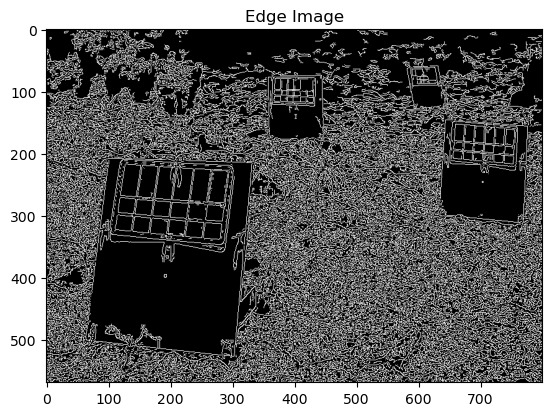

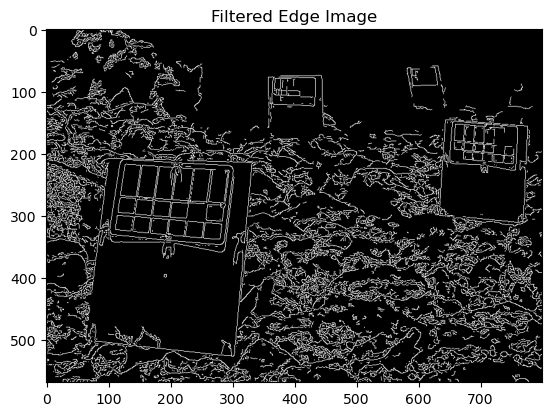

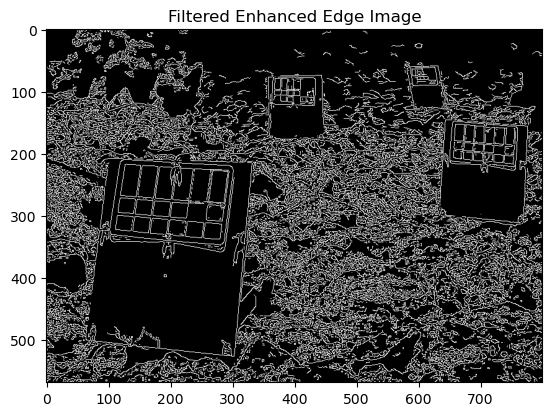

In [131]:
# test canny edge detection
img = cv.imread('test_img/1.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,15)
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,30,80)
plt.clf()
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image')
plt.show()

# test with selective filter blur
blur = cv.bilateralFilter(img,10,50,50)
edges = cv.Canny(blur,30,50)
plt.clf()
plt.imshow(edges,cmap = 'gray')
plt.title('Filtered Edge Image')
plt.show()

# f = open('data/target_edges.txt','w')
# f.write(str(np.array(edges)))
# f.close()

# test with equalize then selective blur
dst = cv.equalizeHist(img)
blur = cv.bilateralFilter(dst,10,50,50)
edges = cv.Canny(blur,30,50)
plt.clf()
plt.imshow(edges,cmap = 'gray')
plt.title('Filtered Enhanced Edge Image')
plt.show()

In [ ]:
## test corner detection
img = cv.imread('test_img/reference.png', cv.IMREAD_GRAYSCALE)
# gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(img,80,0.01,10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),3,255,-1)
plt.imshow(img,cmap = 'gray'),plt.show()

# test with selective filter blur
blur = cv.bilateralFilter(img,12,50,50)
corners = cv.goodFeaturesToTrack(blur,80,0.01,10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(blur,(x,y),3,255,-1)
plt.imshow(blur,cmap = 'gray'),plt.show()

# test with equalize then selective blur
dst = cv.equalizeHist(img)
blur = cv.bilateralFilter(dst,12,50,50)
corners = cv.goodFeaturesToTrack(blur,80,0.01,10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(blur,(x,y),3,255,-1)
plt.imshow(blur,cmap = 'gray'),plt.show()

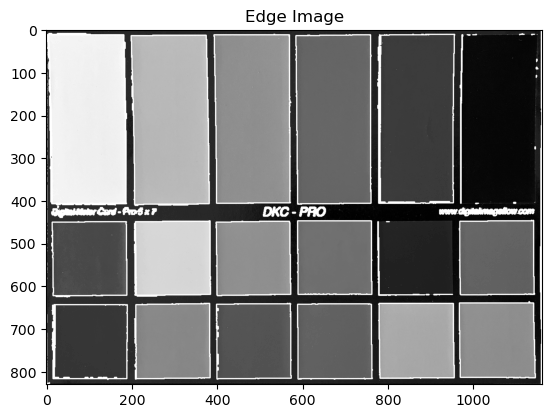

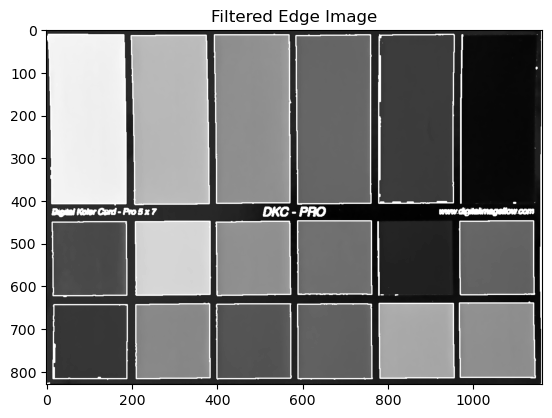

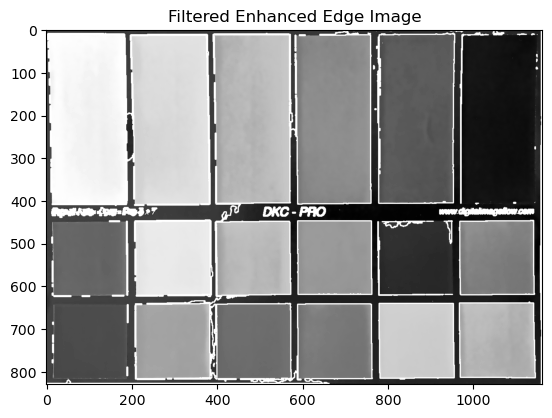

In [135]:
im = cv.imread('test_img/reference.png', cv.IMREAD_GRAYSCALE)
assert im is not None, "file could not be read, check with os.path.exists()"
# imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(im, 50, 100, 0)
contours = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
cnt = []
for c in contours:
    if cv.arcLength(c,True) > 10:
#         cnt.append(cv.convexHull(c))
        cnt.append(c)
result = im.copy()
cv.drawContours(result, cnt, -1, (255,0,0), 2)
plt.clf()
plt.imshow(result,cmap = 'gray')
plt.title('Edge Image')
plt.show()

# test with selective filter blur
blur = cv.bilateralFilter(im,10,25,25)
ret, thresh = cv.threshold(blur, 50, 30, 0)
contours = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
cnt = []
for c in contours:
    if cv.arcLength(c,True) > 10:
#         cnt.append(cv.convexHull(c))
        cnt.append(c)
result = blur.copy()
cv.drawContours(result, cnt, -1, (255,0,0), 2)
plt.clf()
plt.imshow(result,cmap = 'gray')
plt.title('Filtered Edge Image')
plt.show()

# test with equalize then selective blur
dst = cv.equalizeHist(im)
blur = cv.bilateralFilter(dst,10,25,25)
ret, thresh = cv.threshold(blur, 50, 30, 0)
contours = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
cnt = []
for c in contours:
    if cv.arcLength(c,True) > 10:
#         cnt.append(cv.convexHull(c))
        cnt.append(c)
result = blur.copy()
cv.drawContours(result, cnt, -1, (255,0,0), 2)
plt.clf()
plt.imshow(result,cmap = 'gray')
plt.title('Filtered Enhanced Edge Image')
plt.show()

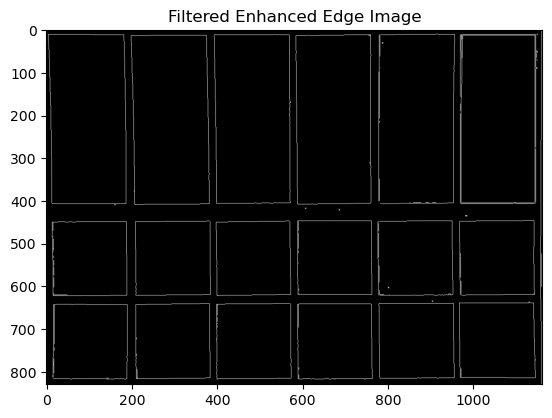

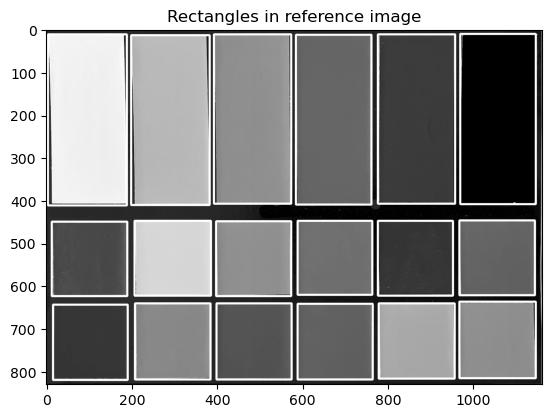

In [303]:
# test processing of reference image

# process reference image
img = cv.imread('test_img/reference.png', cv.IMREAD_GRAYSCALE)
height = len(img)
width = len(img[0])
# img = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,15)
assert img is not None, "file could not be read, check with os.path.exists()"

# canny edge detection
dst = cv.equalizeHist(img)
blur = cv.bilateralFilter(dst,5,50,50)
ref_edges = cv.Canny(blur,100,250)
# exp = cv.copyMakeBorder(edges, 10, 10, 10, 10, cv.BORDER_CONSTANT, None, value = 0)
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (4,4))
# blob = cv.morphologyEx(exp, cv.MORPH_CLOSE, kernel)
# blob = cv.morphologyEx(blob, cv.MORPH_GRADIENT, kernel)
# blob = cv.morphologyEx(blob, cv.MORPH_CLOSE, kernel)
# blob = cv.morphologyEx(blob, cv.MORPH_OPEN, kernel)
# blob = cv.morphologyEx(blob, cv.MORPH_CLOSE, kernel)
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2,2))
# blob = cv.erode(blob,kernel,iterations = 1)
plt.clf()
plt.imshow(ref_edges,cmap = 'gray')
plt.title('Filtered Enhanced Edge Image')
plt.show()

# detect contours
ret, thresh = cv.threshold(img, 50, 150, 0)
contours = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
cnt = []
max_contour = max(contours, key=cv.contourArea)
max_size = cv.contourArea(max_contour)
max_length = cv.arcLength(max_contour,True)
for c in contours:
    if cv.contourArea(c) > max_size/4 and cv.arcLength(c,True) > max_length/4:
#         cnt.append(cv.convexHull(c))
        cnt.append(c)
# result = img.copy()
# cv.drawContours(result, cnt, -1, (255,0,0), 3)
# plt.clf()
# plt.imshow(result,cmap = 'gray')
# plt.title('Contours')
# plt.show()

# find rectangles based on contours, assume contours capture all rectangles
rects = {}
listx = {}
listy = {}
listrects = []
blur = min(20,min(height,width)//2//len(cnt)) # for robust counting of rectangles
result = img.copy()
for c in cnt:
    x,y,w,h = cv.boundingRect(c)
    unique = True
    recordx = True
    recordy = True
    for i in range(-blur,blur):
        if recordx and x+i in listx:
            recordx = False
        for j in range(-blur,blur):
            if (x+i,y+j) in rects:
                unique = False
            if recordy and y+j in listy:
                recordy = False
    if unique:
        rects[(x,y)] = (w,h)
        listrects.append((x,y,w,h))
        cv.rectangle(result, (x, y), (x + w, y + h), (255, 0, 0), 3)
    if recordx:
        listx[x] = True
        listy[y] = True
plt.clf()
plt.imshow(result,cmap = 'gray')
plt.title('Rectangles in reference image')
plt.show()

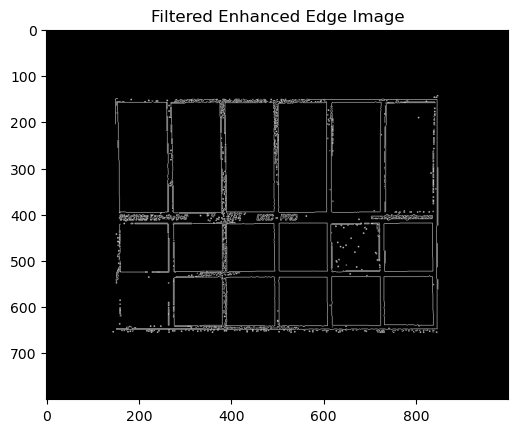

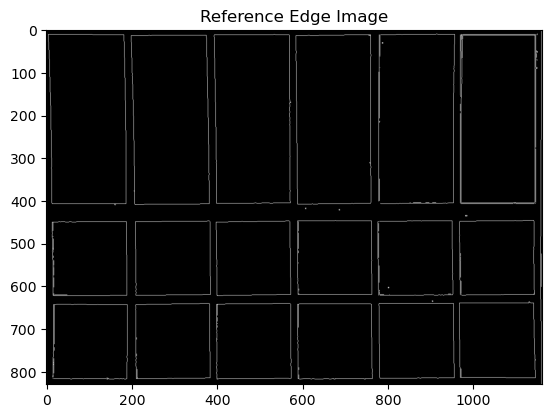

In [316]:
# test detection by comparing canny edges with target

# read environment image
img = cv.imread('test_img/rescaled/0.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,15)
assert img is not None, "file could not be read, check with os.path.exists()"
height = len(img)
width = len(img[0])

# equalize then selective blur before edge detection 
dst = cv.equalizeHist(img)
blur = cv.bilateralFilter(dst,8,50,50)
edges = cv.Canny(blur,30,50)
plt.clf()
plt.imshow(edges,cmap = 'gray')
plt.title('Filtered Enhanced Edge Image')
plt.show()
plt.clf()
plt.imshow(ref_edges,cmap = 'gray')
plt.title('Reference Edge Image')
plt.show()

In [318]:
import torch

In [ ]:
class ReferenceInImage:
    def __init__(self,reference_path,image_path,apply_filters=True):
        super().__init__()
        self.reference_img = cv.imread(reference_path, cv.IMREAD_GRAYSCALE)
        self.reference_height = len(img)
        self.reference_width = len(img[0])
        dst = cv.equalizeHist(img)
        blur = cv.bilateralFilter(dst,5,50,50)
        self.reference_edges = cv.Canny(blur,100,250)
#         plt.clf()
#         plt.imshow(ref_edges,cmap = 'gray')
#         plt.title('Filtered Enhanced Edge Image')
#         plt.show()
        
        self.img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        self.height = len(img)
        self.width = len(img[0])
        if apply_filters:
            dst = cv.equalizeHist(img)
            blur = cv.bilateralFilter(dst,8,50,50)
            self.edges = cv.Canny(blur,30,50)
plt.clf()
plt.imshow(edges,cmap = 'gray')
plt.title('Filtered Enhanced Edge Image')
plt.show()
plt.clf()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'